In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, Model
import numpy as np
import pandas as pd
import os

In [2]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.3.1
Hub version:  0.10.0
Eager mode:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


### Transfer Learning

In [3]:
data_root = '../../Images/Merged_Categories'

In [4]:
# Create data generator for training and validation

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 90 images belonging to 6 classes.
Found 368 images belonging to 6 classes.


In [5]:
# Learn more about data batches

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 6)


In [6]:
# Learn about dataset labels

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Cardboard' 'Glass' 'Metal' 'Paper' 'Plastic' 'Trash']


In [34]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_13 (Dense)             (None, 128)               163968    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 774       
Total params: 2,422,726
Trainable params: 164,742
Non-trainable params: 2,257,984
_________________________________________________________________


In [35]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [49]:
# Run model training

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit_generator(
    generator=train_generator, 
    epochs=50,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)]).history

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/50
12/12 [==============================] - 8s 637ms/step - loss: 0.3251 - acc: 0.8859 - val_loss: 1.2280 - val_acc: 0.5000
Epoch 2/50
12/12 [==============================] - 7s 603ms/step - loss: 0.2854 - acc: 0.9130 - val_loss: 1.2375 - val_acc: 0.5333
Epoch 3/50
12/12 [==============================] - 7s 617ms/step - loss: 0.2073 - acc: 0.9620 - val_loss: 1.2475 - val_acc: 0.5000
Epoch 4/50
12/12 [==============================] - 7s 611ms/step - loss: 0.1654 - acc: 0.9565 - val_loss: 1.3383 - val_acc: 0.4444
Epoch 5/50
12/12 [==============================] - 8s 636ms/step - loss: 0.1509 - acc: 0.9701 - val_loss: 1.3131 - val_acc: 0.5111
Epoch 6/50
12/12 [==============================] - 7s 615ms/step - loss: 0.1206 - acc: 0.9647 - val_loss: 1.3565 - val_acc: 0.5000
Epoch 7/50
12/12 [==============================] - 7s 620ms/step - loss: 0.1185 - acc: 0.9701 - val_loss: 1.3301 - val_acc: 0.5222
Epoch 8/50
12/12 [==============================] - 7s 605ms/step - loss: 0.

In [37]:
# Measure accuracy and loss after training

final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)

3/3 [==============================] - 1s 313ms/step - loss: 1.1383 - acc: 0.4556


In [38]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 1.14
Final accuracy: 45.56%


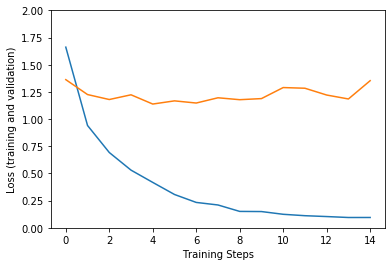

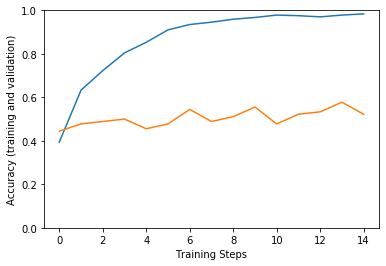

In [39]:
# Visualize training process

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

### Save and Load Model

In [40]:
RACOON_SAVED_MODEL = "saved_models/racoon"
tf.saved_model.save(model, RACOON_SAVED_MODEL)

INFO:tensorflow:Assets written to: saved_models/racoon\assets


INFO:tensorflow:Assets written to: saved_models/racoon\assets


In [41]:
# Load SavedModel

racoon_model = hub.load(RACOON_SAVED_MODEL)
print(racoon_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x00000161848A0448>


In [42]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [43]:
tf_model_predictions = racoon_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 6)


In [44]:
# Convert prediction results to Pandas dataframe, for better visualization

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Cardboard,Glass,Metal,Paper,Plastic,Trash
0,0.540494,0.029550,0.028551,0.192164,0.003840,0.205400
1,0.907346,0.002989,0.001409,0.063153,0.000875,0.024230
2,0.419012,0.003192,0.006336,0.022904,0.007274,0.541282
3,0.001149,0.856774,0.106859,0.001059,0.031685,0.002475
4,0.011599,0.091288,0.747611,0.002216,0.142996,0.004290


In [45]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

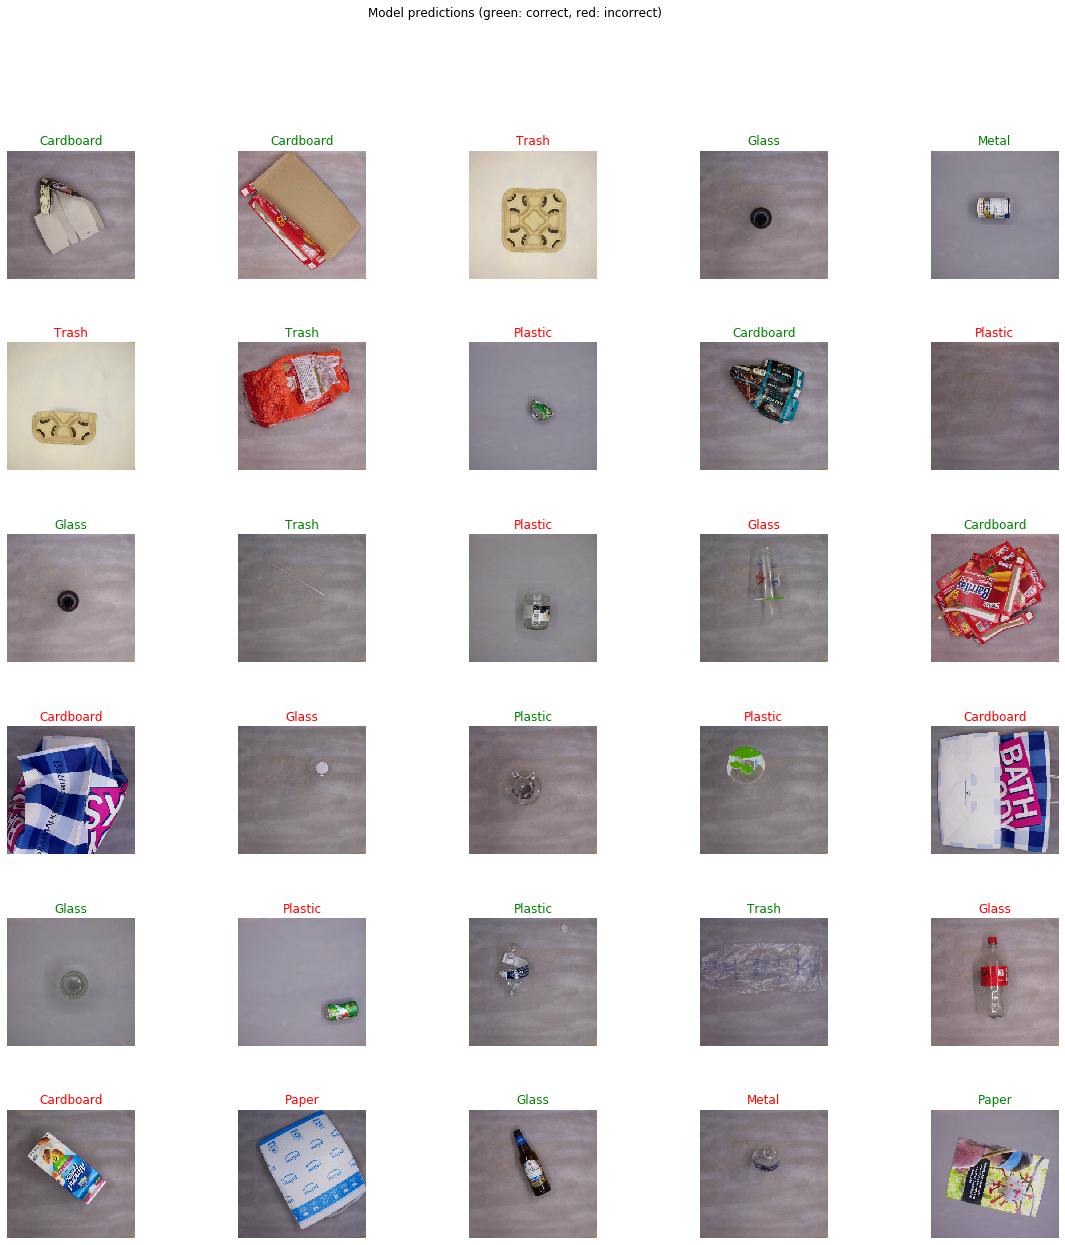

In [46]:
# Print images batch and labels predictions

plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

### Convert model to TFLite

In [37]:
!mkdir "tflite_models"

A subdirectory or file tflite_models already exists.


In [38]:
TFLITE_MODEL = "tflite_models/racoon.tflite"

In [39]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : racoon_model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

print("TFLite models and their sizes:")
!ls "tflite_models" -lh

TFLite models and their sizes:


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [40]:
# Load TFLite model and see some details about input/output

tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [1 1 1 1]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [1 6]
type: <class 'numpy.float32'>


In [41]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 13))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [ 32 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [32  6]
type: <class 'numpy.float32'>


In [42]:
tflite_interpreter.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter.invoke()

tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)

Prediction results shape: (32, 6)


In [43]:
# Convert prediction results to Pandas dataframe, for better visualization

tflite_pred_dataframe = pd.DataFrame(tflite_model_predictions)
tflite_pred_dataframe.columns = dataset_labels

print("TFLite prediction results for the first elements")
tflite_pred_dataframe.head()

TFLite prediction results for the first elements


,Cardboard,Glass,Metal,Paper,Plastic,Trash
0,0.029271,0.285217,0.010601,0.010566,0.620972,0.043373
1,0.714269,0.066223,0.005256,0.051118,0.022605,0.140528
2,0.765766,0.002582,0.007034,0.135828,0.001759,0.087031
3,0.009552,0.308033,0.046709,0.186187,0.308277,0.141243
4,0.006094,0.021424,0.947709,0.000077,0.021133,0.003563


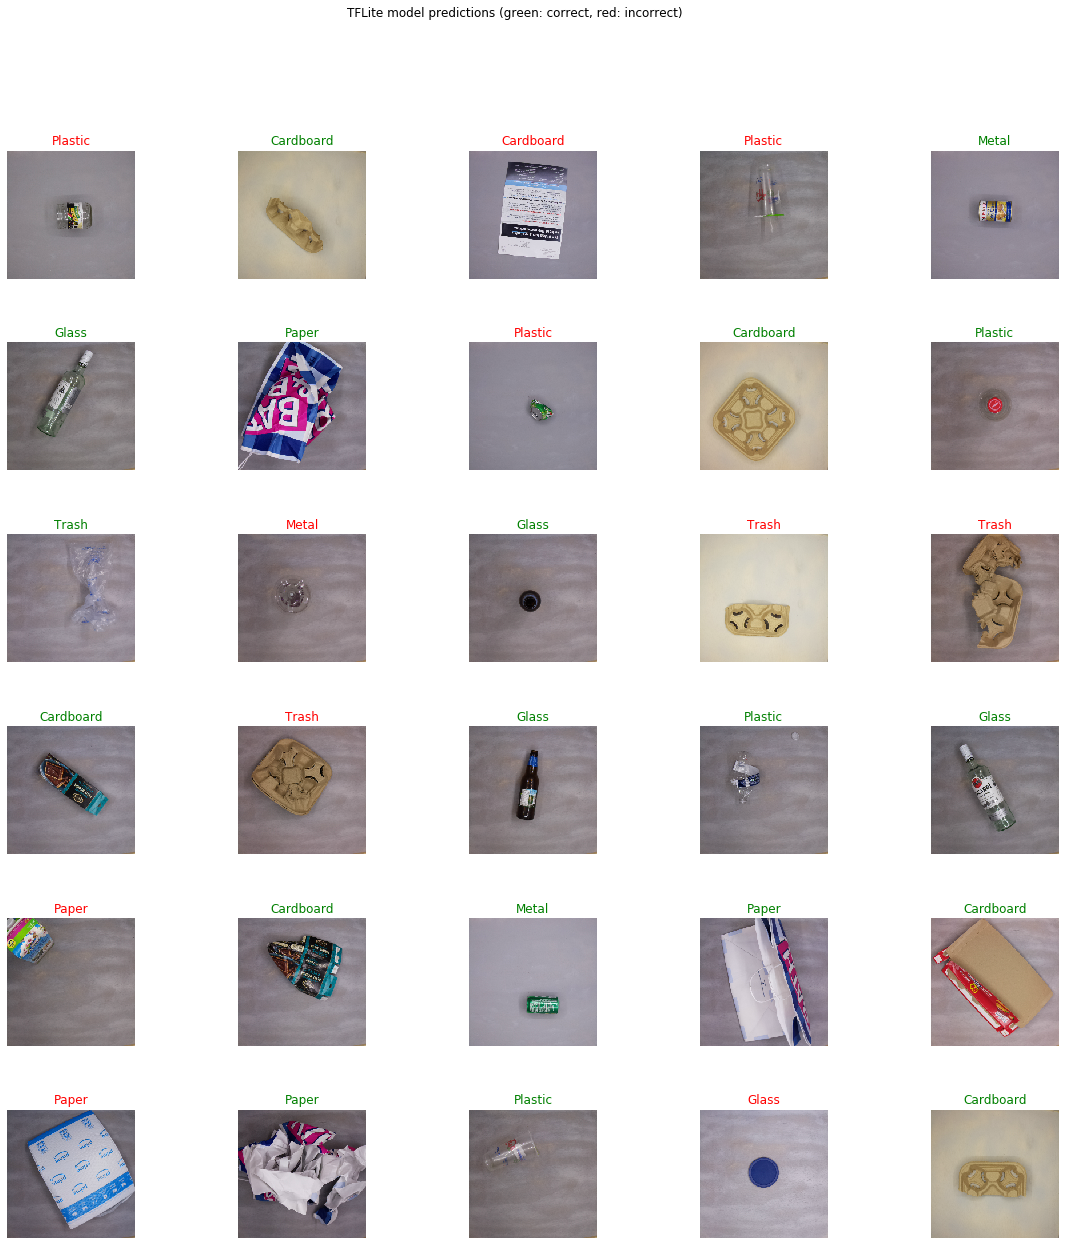

In [51]:
# Print images batch and labels predictions for TFLite Model

tflite_predicted_ids = np.argmax(tflite_model_predictions, axis=-1)
tflite_predicted_labels = dataset_labels[tflite_predicted_ids]
tflite_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(val_image_batch[n])
    color = "green" if tflite_predicted_ids[n] == true_label_ids[n] else "red"
    plt.title(tflite_predicted_labels[n].title(), color=color)
    plt.axis('off')
    _ = plt.suptitle("TFLite model predictions (green: correct, red: incorrect)")

### Getting Output Predictions

In [46]:
tflite_predicted_ids

array([4, 0, 0, 4, 2, 1, 3, 4, 0, 4, 5, 2, 1, 5, 5, 0, 5, 1, 4, 1, 3, 0,
       2, 3, 0, 3, 3, 4, 1, 0, 0, 1], dtype=int64)

In [48]:
tflite_pred_dataframe

,Cardboard,Glass,Metal,Paper,Plastic,Trash
0,0.029271,0.285217,0.010601,0.010566,0.620972,0.043373
1,0.714269,0.066223,0.005256,0.051118,0.022605,0.140528
2,0.765766,0.002582,0.007034,0.135828,0.001759,0.087031
3,0.009552,0.308033,0.046709,0.186187,0.308277,0.141243
4,0.006094,0.021424,0.947709,0.000077,0.021133,0.003563
5,0.016388,0.797601,0.062785,0.010166,0.058617,0.054443
6,0.480763,0.000469,0.003861,0.486459,0.001486,0.026963
7,0.003622,0.298239,0.310838,0.005211,0.375804,0.006286
8,0.487452,0.005307,0.003311,0.037773,0.010628,0.455528
9,0.001791,0.420201,0.041596,0.001365,0.526062,0.008985


In [50]:
true_label_ids

array([1, 0, 3, 5, 2, 1, 3, 2, 0, 4, 5, 4, 1, 0, 0, 0, 0, 1, 4, 1, 5, 0,
       2, 3, 0, 5, 3, 4, 4, 0, 0, 2], dtype=int64)

In [113]:
num = 0
for i in iter(train_generator):
    print('num: ', num)
    print('length: ', len(i))
    num += 1

num:  0
length:  2
num:  1
length:  2
num:  2
length:  2
num:  3
length:  2
num:  4
length:  2
num:  5
length:  2
num:  6
length:  2
num:  7
length:  2
num:  8
length:  2
num:  9
length:  2
num:  10
length:  2
num:  11
length:  2
num:  12
length:  2
num:  13
length:  2
num:  14
length:  2
num:  15
length:  2
num:  16
length:  2
num:  17
length:  2
num:  18
length:  2
num:  19
length:  2
num:  20
length:  2
num:  21
length:  2
num:  22
length:  2
num:  23
length:  2
num:  24
length:  2
num:  25
length:  2
num:  26
length:  2
num:  27
length:  2
num:  28
length:  2
num:  29
length:  2
num:  30
length:  2
num:  31
length:  2
num:  32
length:  2
num:  33
length:  2
num:  34
length:  2
num:  35
length:  2
num:  36
length:  2
num:  37
length:  2
num:  38
length:  2
num:  39
length:  2
num:  40
length:  2
num:  41
length:  2
num:  42
length:  2
num:  43
length:  2
num:  44
length:  2
num:  45
length:  2
num:  46
length:  2
num:  47
length:  2
num:  48
length:  2
num:  49
length:  2
num:  50
l

num:  396
length:  2
num:  397
length:  2
num:  398
length:  2
num:  399
length:  2
num:  400
length:  2
num:  401
length:  2
num:  402
length:  2
num:  403
length:  2
num:  404
length:  2
num:  405
length:  2
num:  406
length:  2
num:  407
length:  2
num:  408
length:  2
num:  409
length:  2
num:  410
length:  2
num:  411
length:  2
num:  412
length:  2
num:  413
length:  2
num:  414
length:  2
num:  415
length:  2
num:  416
length:  2
num:  417
length:  2
num:  418
length:  2
num:  419
length:  2
num:  420
length:  2
num:  421
length:  2
num:  422
length:  2
num:  423
length:  2
num:  424
length:  2
num:  425
length:  2
num:  426
length:  2
num:  427
length:  2
num:  428
length:  2
num:  429
length:  2
num:  430
length:  2
num:  431
length:  2
num:  432
length:  2
num:  433
length:  2
num:  434
length:  2
num:  435
length:  2
num:  436
length:  2
num:  437
length:  2
num:  438
length:  2
num:  439
length:  2
num:  440
length:  2
num:  441
length:  2
num:  442
length:  2
num:  443
len

KeyboardInterrupt: 

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from efficientnet import tfkeras as efn

In [8]:
# base_model = VGG16(input_shape = (224, 224, 3),
#                   include_top = False,
#                   weights = 'imagenet')


base_model = efn.EfficientNetB7(input_shape = (224, 224, 3),
                               include_top = False,
                               weights = 'imagenet')

In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# flatten outpur layer to 1 dimension
x = layers.Flatten()(base_model.output)
# add a fully connecvted layer with 1024 hidden units and TeLU activation
x = layers.Dense(1024, activation='relu')(x)
# add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# add a final sigmoid layer for classification
x = layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [11]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(train_generator, 
                    epochs=20,
                    verbose=1,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_generator,
                    validation_steps=val_steps_per_epoch, 
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             mode='min',
                                             verbose=1,
                                             patience=10,
                                             restore_best_weights=True)]).history

Epoch 1/20
12/12 [==============================] - 98s 8s/step - loss: 47.7126 - acc: 0.3207 - val_loss: 48.9619 - val_acc: 0.3333
Epoch 2/20
12/12 [==============================] - 96s 8s/step - loss: 29.7155 - acc: 0.4837 - val_loss: 20.9940 - val_acc: 0.4000
Epoch 3/20
12/12 [==============================] - 96s 8s/step - loss: 15.8858 - acc: 0.5897 - val_loss: 20.8028 - val_acc: 0.4667
Epoch 4/20
12/12 [==============================] - 97s 8s/step - loss: 11.1937 - acc: 0.5815 - val_loss: 13.4049 - val_acc: 0.3889
Epoch 5/20
12/12 [==============================] - 102s 8s/step - loss: 8.4825 - acc: 0.6223 - val_loss: 11.2097 - val_acc: 0.3667
Epoch 6/20
12/12 [==============================] - 100s 8s/step - loss: 8.7276 - acc: 0.6168 - val_loss: 9.9373 - val_acc: 0.4444
Epoch 7/20
12/12 [==============================] - 99s 8s/step - loss: 11.4588 - acc: 0.6603 - val_loss: 9.3595 - val_acc: 0.3556
Epoch 8/20


KeyboardInterrupt: 